In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix, get_complexity,\
                 group_metrics
from surrogate_tree import train_surrogate_tree, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_rules_of_tree_for_class,\
                 tree_to_constraint_matrix, extract_rules, print_rules,\
                 get_pruned_trees, eval_trees

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [5]:
%%time
trees = []
full_tree = train_surrogate_tree(X, mclass_diff)
trees = get_pruned_trees(full_tree, X, mclass_diff)
tree_it = iter(trees)
[tree.get_n_leaves() for tree in trees]

CPU times: user 9.82 ms, sys: 1.31 ms, total: 11.1 ms
Wall time: 12.8 ms


[2, 3, 5, 6, 8]

In [6]:
trees[-1].get_depth()

4

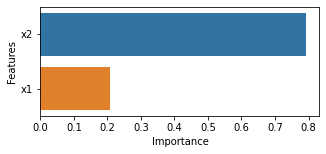

In [7]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

## 2 Leafs

In [8]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.05361218092252575, 1, 2)

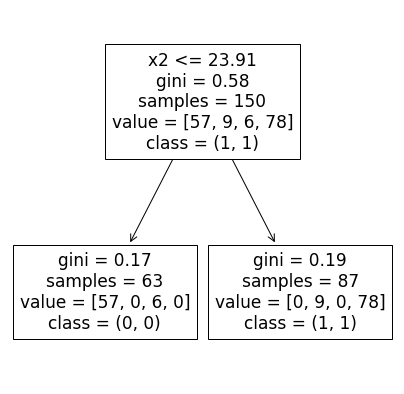

In [9]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [10]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

## 3 Leafs

In [11]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.03619047619047619, 2, 3)

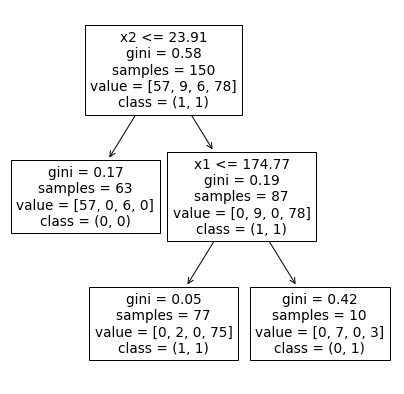

In [12]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [13]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 174.8 and x2 > 23.9 => (0, 1) [0, 7, 0, 3]


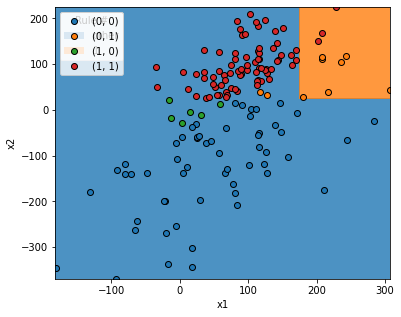

In [14]:
plot_rules_of_tree_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names, rule_order)

## 5 Leafs

In [15]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.028, 3, 5)

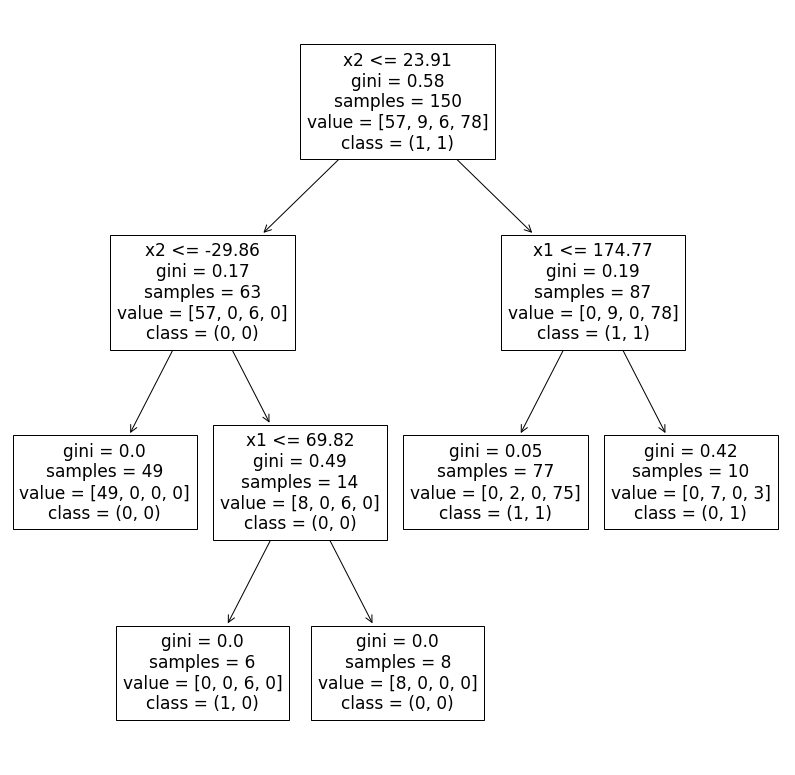

In [16]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [17]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 174.8 and x2 > 23.9 => (0, 1) [0, 7, 0, 3]
2. x1 <= 69.8 and -29.9 < x2 <= 23.9 => (1, 0) [0, 0, 6, 0]


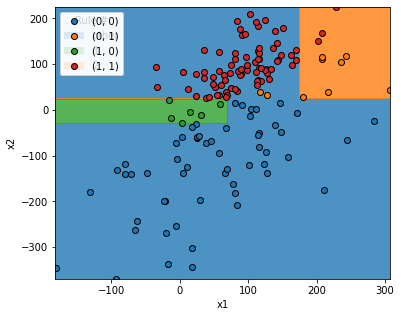

In [18]:
plot_rules_of_tree_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names, rule_order)

## 6 Leafs

In [19]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.012987012987012993, 3, 6)

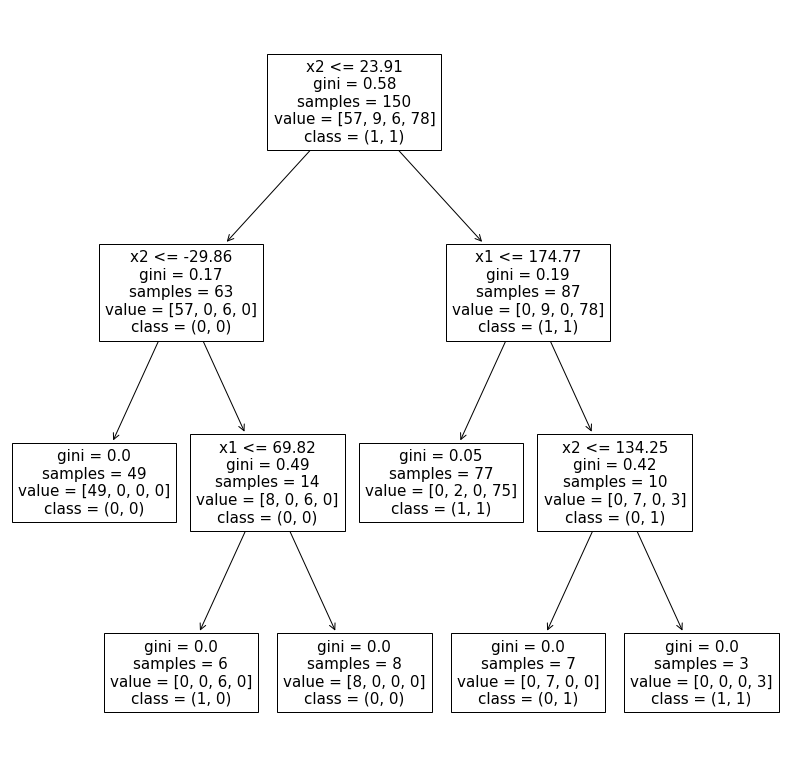

In [20]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [21]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 174.8 and 23.9 < x2 <= 134.3 => (0, 1) [0, 7, 0, 0]
2. x1 <= 69.8 and -29.9 < x2 <= 23.9 => (1, 0) [0, 0, 6, 0]


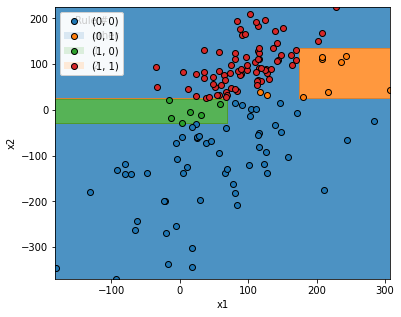

In [22]:
plot_rules_of_tree_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names, rule_order)

## 8 Leafs

In [23]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 4, 8)

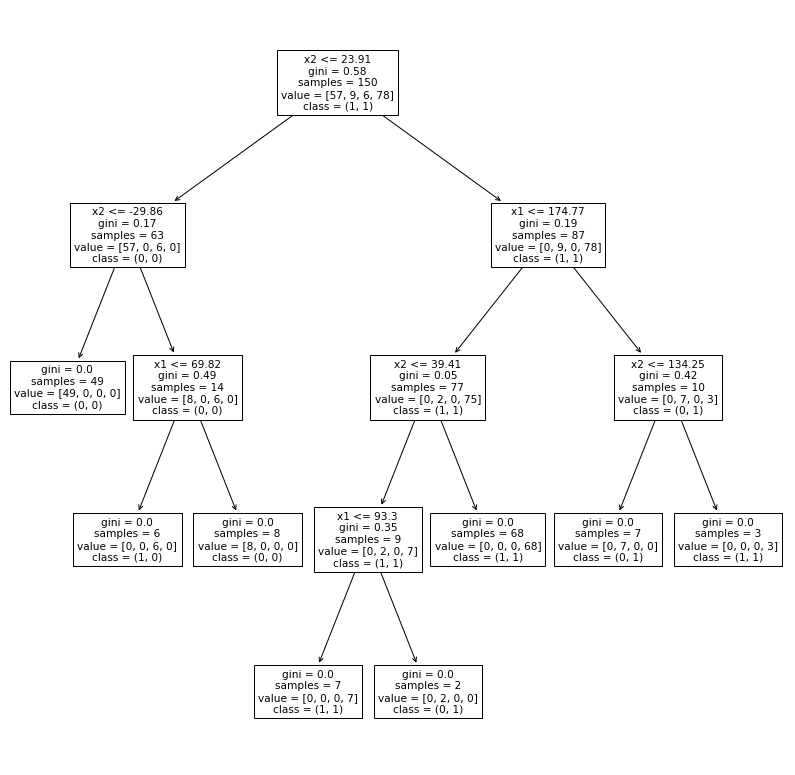

In [24]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [25]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 174.8 and 23.9 < x2 <= 134.3 => (0, 1) [0, 7, 0, 0]
2. x1 <= 69.8 and -29.9 < x2 <= 23.9 => (1, 0) [0, 0, 6, 0]
3. 93.3 < x1 <= 174.8 and 23.9 < x2 <= 39.4 => (0, 1) [0, 2, 0, 0]


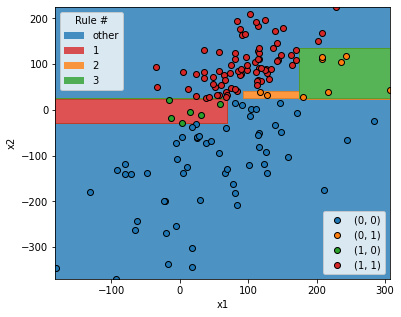

In [26]:
plot_rules_of_tree_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names, rule_order)
ax = plt.gca()
ax.get_legend().remove()
ax.legend(*ax.get_legend_handles_labels(), loc='lower right')
plt.savefig('figures/bign-baseline-final.pdf', bbox_inches='tight', pad_inches=0)

In [27]:
def get_predicted_rules(indices=None):
    indices = np.where(np.in1d(mclass_diff, comparer.difference_classes))[0] if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=indices)

In [28]:
pred_rules = get_predicted_rules()
pred_rules.index[pd.isna(pred_rules)]

Int64Index([], dtype='int64')

# Evaluation

In [29]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [30]:
metrics = eval_trees(trees, feature_names, comparer.class_names, X_test=X_test, y_test=y_test)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
"(0, 0)",0.770765,1.000000,0.870544,4213.0,"(0, 0)",2,0.053612,1,1
"(1, 1)",0.782753,0.991895,0.875000,3578.0,"(1, 1)",2,0.053612,1,1
"(0, 0)",0.770765,1.000000,0.870544,4213.0,"(0, 0)",3,0.036190,1,1
"(0, 1)",0.734969,0.586680,0.652505,1021.0,"(0, 1)",3,0.036190,1,2
"(1, 1)",0.896209,0.931526,0.913526,3578.0,"(1, 1)",3,0.036190,1,2
"(0, 0)",0.900664,0.966295,0.932326,4213.0,"(0, 0)",5,0.028000,2,4
"(0, 1)",0.734969,0.586680,0.652505,1021.0,"(0, 1)",5,0.028000,1,2
"(1, 0)",0.826638,0.658249,0.732896,1188.0,"(1, 0)",5,0.028000,1,3
"(1, 1)",0.896209,0.931526,0.913526,3578.0,"(1, 1)",5,0.028000,1,2
"(0, 0)",0.900664,0.966295,0.932326,4213.0,"(0, 0)",6,0.012987,2,4


In [31]:
metrics.query('Leafs == 8')

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
"(0, 0)",0.900664,0.966295,0.932326,4213.0,"(0, 0)",8,0.0,2,4
"(0, 1)",0.931990,0.724780,0.815427,1021.0,"(0, 1)",8,0.0,2,7
"(1, 0)",0.826638,0.658249,0.732896,1188.0,"(1, 0)",8,0.0,1,3
"(1, 1)",0.934492,0.976803,0.955179,3578.0,"(1, 1)",8,0.0,3,7


In [36]:
grouped_metrics, constraints = group_metrics(metrics, by='Alpha')

In [37]:
with open('data/fidelity-baseline.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

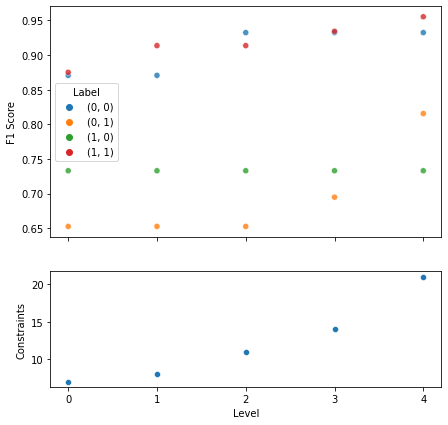

In [38]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 7), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [39]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Leafs     Alpha  \
Level                                                                      
0     0  (0, 0)   0.770765  1.000000  0.870544   4213.0    2.0  0.053612   
      1  (0, 1)   0.734969  0.586680  0.652505   1021.0    3.0  0.036190   
      2  (1, 0)   0.826638  0.658249  0.732896   1188.0    5.0  0.028000   
      3  (1, 1)   0.782753  0.991895  0.875000   3578.0    2.0  0.053612   
1     0  (0, 0)   0.770765  1.000000  0.870544   4213.0    3.0  0.036190   
      1  (0, 1)   0.734969  0.586680  0.652505   1021.0    3.0  0.036190   
      2  (1, 0)   0.826638  0.658249  0.732896   1188.0    5.0  0.028000   
      3  (1, 1)   0.896209  0.931526  0.913526   3578.0    3.0  0.036190   
2     0  (0, 0)   0.900664  0.966295  0.932326   4213.0    5.0  0.028000   
      1  (0, 1)   0.734969  0.586680  0.652505   1021.0    5.0  0.028000   
      2  (1, 0)   0.826638  0.658249  0.732896   1188.0    5.0  0.028000   
      3  (1, 1)   0.896209  0.931526  0.913526   3578.0    5.0  0.028000   
3     0  (0, 0)   0.900664  0.966295  0.932326   4213.0    6.0  0.012987   
      1  (0, 1)   0.922204  0.557297  0.694750   1021.0    6.0  0.012987   
      2  (1, 0)   0.826638  0.658249  0.732896   1188.0    6.0  0.012987   
      3  (1, 1)   0.893796  0.978480  0.934223   3578.0    6.0  0.012987   
4     0  (0, 0)   0.900664  0.966295  0.932326   4213.0    8.0  0.000000   
      1  (0, 1)   0.931990  0.724780  0.815427   1021.0    8.0  0.000000   
      2  (1, 0)   0.826638  0.658249  0.732896   1188.0    8.0  0.000000   
      3  (1, 1)   0.934492  0.976803  0.955179   3578.0    8.0  0.000000   

         Rules  Constraints  
Level                        
0     0    1.0          1.0  
      1    1.0          2.0  
      2    1.0          3.0  
      3    1.0          1.0  
1     0    1.0          1.0  
      1    1.0          2.0  
      2    1.0          3.0  
      3    1.0          2.0  
2     0    2.0          4.0  
      1    1.0          2.0  
      2    1.0          3.0  
      3    1.0          2.0  
3     0    2.0          4.0  
      1    1.0          3.0  
      2    1.0          3.0  
      3    2.0          4.0  
4     0    2.0          4.0  
      1    2.0          7.0  
      2    1.0          3.0  
      3    3.0          7.0

In [40]:
constraints

Level
0     7.0
1     8.0
2    11.0
3    14.0
4    21.0
Name: Constraints, dtype: float64

# Additional Material